# Implementação do Modelo de Regressão Linear com Regularização Ridge (L2)

## Importando as bibliotecas

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---

## Importando o conjunto de dados

In [37]:
data = pd.read_csv('adm_data.csv')
data.rename(columns = {'Chance of Admit ': 'Chance of Admit'}, inplace = True)
data.rename(columns = {'LOR ': 'LOR'}, inplace = True)

In [38]:
features = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']
label = 'Chance of Admit'

---

## Modelo com Regularização para Complexidade: Regularização Ridge ou L2

Iremos modificar o modelo implementado anteriormente e adicionar o termo de complexidade à função de custo, definindo-o pela fórmula de regularização $L_{2}$ ($L_{2}$ Regularization formula). Tal termo é dado por:

$L_{2}$ regularization term = $ \sum_{i = 1}^{m} w_{i}^{2}$

Definimos $\lambda$ como o coeficiente de regularização, um hiperparâmetro do modelo que multiplica a função de complexidade. Quanto maior $\lambda$, maior o efeito de regularização na complexidade, isto é, mais penalizados os pesos muito grandes nas features são. Dessa forma, a nova função que se quer minimizar no modelo é dada por:

$f(\theta)$ = Loss + $\lambda$ Complexity = $\frac{1}{n} \sum_{i = 1}^{n} (\hat{y}_{i} - y_{i})^{2} + \lambda \sum_{i = 1}^{m} w_{i}^{2}$

cujas derivadas parciais são dadas por:

$\frac{\partial f}{\partial w_{k}} = \frac{2}{n}\sum_{i = 1}^{n} (\hat{y}_{i} - y_{i}) \cdot (x_{k})_{i} + 2\lambda w_{k}$, para toda feature $x_{k}$ com peso $w_{k}$.

$\frac{\partial f}{\partial b} = \frac{2}{n}\sum_{i = 1}^{n} (\hat{y}_{i} - y_{i})$

Assim, obtemos os novos valores do peso e do viés após uma iteração:

$w_{k}' = (1 - 2 \alpha \lambda)\;w_{k} - \frac{2 \alpha}{n}\sum_{i = 1}^{n} (\hat{y}_{i} - y_{i}) \cdot (x_{k})_{i}$, para toda feature $x_{k}$ com peso $w_{k}$.


$b' = b - \frac{2 \alpha}{n}\sum_{i = 1}^{n} (\hat{y}_{i} - y_{i})$

---

## Implementação

In [39]:
class RegularizationLinearRegressionModel:
    def __init__(self, features, label, ws: list,
                 b = 0, alpha = 0.1, lambda_reg = 0.1, random_state = 0):
        '''Constructor for the RegularizationLinearRegressionModel class. It takes in eight arguments:

        - features: a Pandas DataFrame containing the features to be used for training the model;
        - label: a Pandas Series containing the label corresponding to the features that will be predicted using the model;
        - ws: a list of floats representing the initial values of the weights (coefficients) of the features;
        - b: a float representing the initial value of the bias term (default value is 0);
        - alpha: a float representing the learning rate (i.e., the size of the step taken in the direction of the gradient during gradient descent) (default value is 0.1);
        - lambda_reg: a float representing the regularization strength (default value is 0.1);
        - random_state: an integer representing the random seed to use for generating random numbers (default value is 0).'''
        self.features = features
        self.label = label
        ws = [float(w) for w in ws]
        self.ws = np.array(ws) # weights
        self.b = b
        self.alpha = alpha
        self.lambda_reg = lambda_reg
        self.rand = np.random.RandomState(random_state)
        
    def print_parameters(self):
        '''Prints the current values of the weights ws and bias b of the model.'''
        for i in range(1, len(self.ws) + 1):
            print(f'w{i} = {self.ws[i - 1]}')
        print (f'b = {self.b}')
        
    def get_parameters(self):
        '''Returns a dictionary containing the current values of the weights ws and bias b of the model. 
        The keys of the dictionary are strings 'w1', 'w2', etc. corresponding to the weights, and 'b' corresponding to the bias.'''
        i_vals = list(range(1, len(self.ws) + 1))
        parameters = {f'w{i}': self.ws[i - 1] for i in i_vals}
        parameters['b'] = self.b
        return parameters
    
    def predict(self, X):
        '''Takes in a Pandas DataFrame X containing feature values 
        and returns a NumPy array of predicted values of the label using 
        the current values of ws and b.'''
        predictions = np.array(X.mul(self.ws).sum(axis = 1) + self.b)
        return predictions
    
    def get_loss(self, X, y):
        '''Takes in a Pandas DataFrame X containing feature values 
        and a Pandas Series y containing the corresponding true label values, 
        and returns the mean squared error loss of the model on the data.'''
        predictions = self.predict(X)
        diff = predictions - y
        loss = np.mean(diff**2)
        return loss
    
    def __get_Xy_sample(self, begin_index, end_index):
        '''Private helper function which from X and y starting in the begin_index 
        row and ending in end_index row.'''
        X = self.features.iloc[begin_index:end_index]
        y = self.label.iloc[begin_index:end_index]
        return X, y
    
    def __get_sample_partial_w(self, X, diff, batch_size):
        '''Private helper function which gets the partial derivative of loss 
        and regularization term with respect to weights for a sample (X).'''
        partial_w = (2/batch_size) * (diff @ X) + 2*self.lambda_reg*self.ws
        return partial_w
    
    def __get_sample_partial_b(self, diff, batch_size):
        partial_b = (2/batch_size) * np.sum(diff)
        return partial_b
    
    def __batch_update_parameters(self, X, diff, batch_size, inexact_batch_size):
        '''Private helper function which updates weights (ws) and bias (b) for a batch.'''
        partial_w = self.__get_sample_partial_w(X, diff, inexact_batch_size)
        partial_b = self.__get_sample_partial_b(diff, inexact_batch_size)
        correction_constant = batch_size/inexact_batch_size
        self.ws -= self.alpha * partial_w * correction_constant
        self.b -= self.alpha * partial_b * correction_constant
    
    def get_complexity(self):
        '''Returns the complexity of the model, 
        which is defined as the sum of the squares of the weights ws.'''
        return np.dot(self.ws, self.ws)
    
    def get_structural_risk(self, X, y):
        '''Takes in a Pandas DataFrame X_test containing feature values 
        and a Pandas Series y_test containing the corresponding true label values,
        and returns the structural risk of the model on the test data. 
        The structural risk is defined as the sum of the mean squared error loss 
        and the complexity of the model, multiplied by the regularization strength lambda_reg.'''
        return self.get_loss(X, y) + self.lambda_reg * self.get_complexity()
    
    def __sgd_update_parameters(self, batch_size: int):
        '''Private helper function that performs one step of stochastic gradient descent on the model's parameters (ws and b). 
        It takes in a single argument batch_size, which is the number of samples to use in the mini-batch for this step of gradient descent. 
        The function first selects mini-batches from the training data, and then performs an update to the model's parameters 
        using the gradient of the mean squared error loss with respect to the parameters for each mini-batch.
        The update is performed using the learning rate alpha.'''
        num_of_data_rows = len(self.label)
        inexact_batch_size = num_of_data_rows % batch_size
        num_of_exact_batches = int(num_of_data_rows/batch_size)
        for exact_batch in range(1, num_of_exact_batches + 1):
            begin_index = (exact_batch - 1) * batch_size
            end_index = exact_batch * batch_size
            X, y = self.__get_Xy_sample(begin_index, end_index)
            predictions = self.predict(X)
            diff = predictions - y
            self.__batch_update_parameters(X, diff, batch_size, batch_size)
        if inexact_batch_size != 0:
            begin_index = (num_of_exact_batches) * batch_size + 1
            end_index = num_of_data_rows + 1
            X, y = self.__get_Xy_sample(begin_index, end_index)
            predictions = self.predict(X)
            diff = predictions - y
            self.__batch_update_parameters(X, diff, batch_size, inexact_batch_size)
        
    def sgd(self, iterations: int, batch_size: float, print_loss = False): # stochastic gradient descent
        '''Performs stochastic gradient descent for a specified number of iterations. It takes in three arguments:

        - iterations: an integer representing the number of iterations of gradient descent to perform
        - batch_size: a float representing the number of samples to use in each mini-batch for each step of gradient descent
        - print_loss: a boolean indicating whether to print the loss after each iteration of gradient descent. 
        If True, the loss will be printed; if False, the loss will not be printed (default value is False).'''
        for i in range(0, iterations):
            self.__sgd_update_parameters(batch_size)
            if print_loss:
                print(f'loss = {self.get_loss(self.features, self.label)}')
    
    @staticmethod
    def shuffle_data(data, random_state):
        '''Shuffles a Pandas Dataframe's data.'''
        rand = np.random.RandomState(random_state)
        return data.reindex(rand.permutation(data.index))
    
    @staticmethod
    def train_val_test_split(X, y, test_split_factor: float, val_split_factor: float):
        '''Get train, validation and test Pandas Dataframes from X (features) and y (label).'''
        num_of_data_rows = len(y)
        test_size = int(test_split_factor * num_of_data_rows)
        val_size = int(val_split_factor * num_of_data_rows)
        X_test = X.iloc[0:test_size]
        y_test = y.iloc[0:test_size]
        X_val = X.iloc[test_size:test_size + val_size]
        y_val = y.iloc[test_size:test_size + val_size]
        X_train = X.iloc[test_size + val_size:num_of_data_rows]
        y_train = y.iloc[test_size + val_size:num_of_data_rows]
        return X_test, y_test, X_val, y_val, X_train, y_train

---

### Shuffling e Split

In [40]:
random_state = 0
data_shuffled = RegularizationLinearRegressionModel.shuffle_data(data, random_state = random_state)

In [41]:
X = data_shuffled[features]
y = data_shuffled[label]

In [42]:
X_test, y_test, X_val, y_val, X_train, y_train = RegularizationLinearRegressionModel.train_val_test_split(X, y, test_split_factor = 0.2, val_split_factor = 0.2)

---

# Pré-processamento

#### Obs: o pré-processamento deve vir depois do processo de split, para evitar adicionar viés aos dados de teste por influência dos dados de treino.

### Mudando a escala dos dados para [0, 1]

Transformaremos [min, max] -> [0, 1] para cada coluna.

In [43]:
def scale(feature, train_feature):
    minimum = min(train_feature)
    maximum = max(train_feature)
    return (feature - minimum)/(maximum - minimum)

In [44]:
unscaled_X_train= X_train.copy()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()
for feature in features:
    X_train_scaled[feature] = scale(X_train_scaled[feature], unscaled_X_train[feature])
    X_val_scaled[feature] = scale(X_val_scaled[feature], unscaled_X_train[feature])
    X_test_scaled[feature] = scale(X_test_scaled[feature], unscaled_X_train[feature])

---

## Treinamento

#### Vamos variar valores de lambda de 0 a 1 para verificar o que acontece com o custo e com a complexidade do modelo, mantendo os outros parâmetros constantes.

In [45]:
lambda_reg_vals = np.arange(0, 1.1, 0.1)

In [46]:
lambda_reg_vals

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [47]:
ws = list(np.zeros(len(features)))
b = 0
alpha = 0.1
models = []
for lambda_reg in lambda_reg_vals:
    model = RegularizationLinearRegressionModel(features = X_train_scaled,
                                label = y_train, ws = ws, b = b, alpha = alpha, 
                                lambda_reg = lambda_reg, random_state = random_state)
    model.sgd(iterations = 50, batch_size = 40)
    models.append(model)

In [48]:
n = len(lambda_reg_vals)
i_vals = list(range(n))
lambda_row = {f'Model {i}': model.lambda_reg for (i, model) in zip(i_vals, models)}

In [49]:
training_loss_row

{'Model 0': 0.0039226276898096865,
 'Model 1': 0.0057250390532882405,
 'Model 2': 0.007203432884733115,
 'Model 3': 0.008475980998704346,
 'Model 4': 0.009566053957894548,
 'Model 5': 0.010498913771121743,
 'Model 6': 0.011300356652900122,
 'Model 7': 0.011993137960777039,
 'Model 8': 0.01259614649668789,
 'Model 9': 0.013124694624001442,
 'Model 10': 0.013591106351524197}

In [50]:
df_models = pd.DataFrame([lambda_row])
training_loss_row = {f'Model {i}': model.get_loss(X_train_scaled, y_train) for (i, model) in zip(i_vals, models)}
val_loss_row = {f'Model {i}': model.get_loss(X_val_scaled, y_val) for (i, model) in zip(i_vals, models)}
test_loss_row = {f'Model {i}': model.get_loss(X_test_scaled, y_test) for (i, model) in zip(i_vals, models)}
complexity_row = {f'Model {i}': model.get_complexity() for (i, model) in zip(i_vals, models)}

df_models = pd.concat([df_models, pd.DataFrame(training_loss_row, index = ['Training Loss'])], axis = 0)
df_models = pd.concat([df_models, pd.DataFrame(val_loss_row, index = ['Validation Loss'])], axis = 0)
df_models = pd.concat([df_models, pd.DataFrame(test_loss_row, index = ['Test Loss'])], axis = 0)
df_models = pd.concat([df_models, pd.DataFrame(complexity_row, index = ['Complexity'])], axis = 0)
df_models = df_models.rename(index ={0: 'Lambda', 1: 'Training Loss', 2: 'Validation Loss', 3: 'Test Loss', 4: 'Complexity'})

In [51]:
df_models

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8,Model 9,Model 10
Lambda,0.000000,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,1.000000
Training Loss,0.003923,0.005725,0.007203,0.008476,0.009566,0.010499,0.011300,0.011993,0.012596,0.013125,0.013591
Validation Loss,0.004395,0.004876,0.005715,0.006519,0.007241,0.007875,0.008429,0.008913,0.009339,0.009714,0.010047
Test Loss,0.004752,0.005954,0.007051,0.008008,0.008836,0.009551,0.010169,0.010706,0.011175,0.011587,0.011953
Complexity,0.095118,0.031340,0.020590,0.015087,0.011690,0.009403,0.007777,0.006572,0.005652,0.004932,0.004356


Verificamos justamente o esperado:

- __Aumento do valor de Lambda $\rightarrow$ Diminuição da Complexidade e Aumento do Custo do Modelo em todos os dados.__

### Podemos verificar esse fato graficamente também:

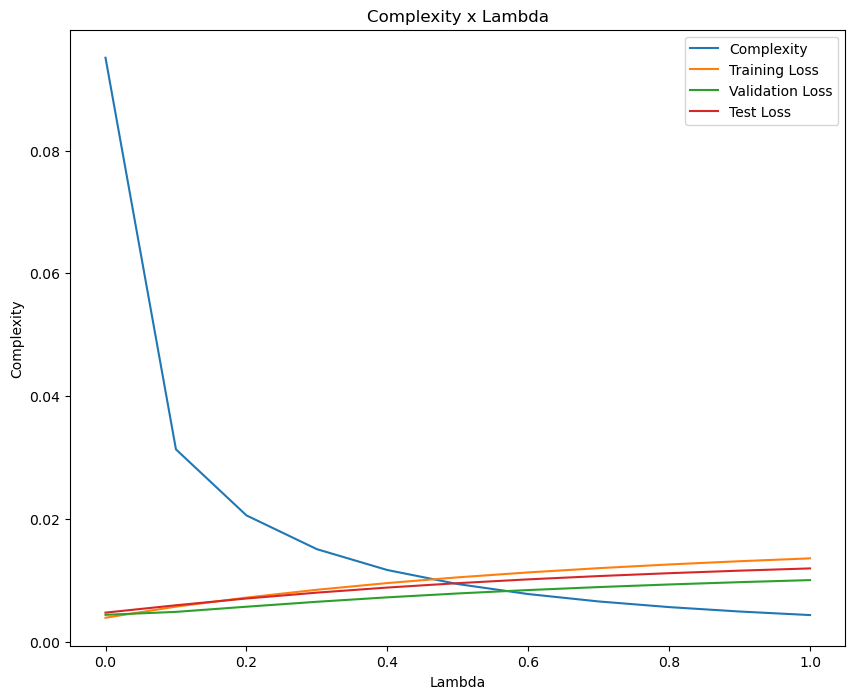

In [52]:
plt.figure(figsize=(10, 8))
plt.plot(lambda_row.values(), complexity_row.values())
plt.plot(lambda_row.values(), training_loss_row.values())
plt.plot(lambda_row.values(), val_loss_row.values())
plt.plot(lambda_row.values(), test_loss_row.values())
plt.title('Complexity x Lambda')
plt.xlabel('Lambda')
plt.ylabel('Complexity')
plt.legend(['Complexity', 'Training Loss', 'Validation Loss', 'Test Loss'])
plt.show()

### Vamos adicionar também o cálculo do risco estrutural para cada modelo em cada conjunto de dados:

In [53]:
training_sr_row = {f'Model {i}': model.get_structural_risk(X_train_scaled, y_train) for (i, model) in zip(i_vals, models)}
val_sr_row = {f'Model {i}': model.get_structural_risk(X_val_scaled, y_val) for (i, model) in zip(i_vals, models)}
test_sr_row = {f'Model {i}': model.get_structural_risk(X_test_scaled, y_test) for (i, model) in zip(i_vals, models)}

df_models = pd.concat([df_models, pd.DataFrame(training_sr_row, index = ['Training Structural Risk'])])
df_models = pd.concat([df_models, pd.DataFrame(val_sr_row, index = ['Validation Structural Risk'])])
df_models = pd.concat([df_models, pd.DataFrame(test_sr_row, index = ['Test Structural Risk'])])

In [54]:
df_models

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8,Model 9,Model 10
Lambda,0.000000,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,1.000000
Training Loss,0.003923,0.005725,0.007203,0.008476,0.009566,0.010499,0.011300,0.011993,0.012596,0.013125,0.013591
Validation Loss,0.004395,0.004876,0.005715,0.006519,0.007241,0.007875,0.008429,0.008913,0.009339,0.009714,0.010047
Test Loss,0.004752,0.005954,0.007051,0.008008,0.008836,0.009551,0.010169,0.010706,0.011175,0.011587,0.011953
Complexity,0.095118,0.031340,0.020590,0.015087,0.011690,0.009403,0.007777,0.006572,0.005652,0.004932,0.004356
Training Structural Risk,0.003923,0.008859,0.011321,0.013002,0.014242,0.015201,0.015966,0.016594,0.017118,0.017563,0.017947
Validation Structural Risk,0.004395,0.008010,0.009833,0.011045,0.011917,0.012577,0.013095,0.013514,0.013861,0.014153,0.014403
Test Structural Risk,0.004752,0.009088,0.011169,0.012534,0.013512,0.014253,0.014835,0.015306,0.015697,0.016026,0.016308


- A análise dos riscos estruturais dos modelos nos indica a mesma resposta da análise dos valores de perda do modelo nos dados de treinamento, validação e de teste, que nos leva a crer que o modelo com $lambda = 0$ é o melhor, dado que possui menores perdas e tais valores nos três datasets são muito próximos, negando a possibilidade de overfitting nos dados de treino. Tal modelo também é aquele com os menores riscos estruturais.

### Verificando que de fato os pesos das features diminuem:

In [55]:
i = 0
for model in models:
    print(f'Model {i}')
    model.print_parameters()
    print('\n')
    i += 1

Model 0
w1 = 0.14174274209354215
w2 = 0.10863311875576745
w3 = 0.01776861401521847
w4 = 0.028607824515976366
w5 = 0.1022928246768124
w6 = 0.22656329283530283
w7 = 0.017242106120310127
b = 0.3550341551219084


Model 1
w1 = 0.07984815357187275
w2 = 0.07016538672353434
w3 = 0.06415558817164227
w4 = 0.05460540952416398
w5 = 0.05820468636510164
w6 = 0.08464947849853947
w7 = 0.04889284290124379
b = 0.46845444572051353


Model 2
w1 = 0.06061523471894465
w2 = 0.0547037918805266
w3 = 0.05644712804541835
w4 = 0.04785853676985291
w5 = 0.04687537483079832
w6 = 0.060762210858912584
w7 = 0.05057210405819076
b = 0.518830835851193


Model 3
w1 = 0.05014787412589012
w2 = 0.0456841070618873
w3 = 0.04925327623272098
w4 = 0.041744590697726715
w5 = 0.03991117307578132
w6 = 0.04920415278609769
w7 = 0.047985465705171856
b = 0.5515160074978086


Model 4
w1 = 0.04324066083004081
w2 = 0.039570365347878333
w3 = 0.04363067734603353
w4 = 0.036968511240883656
w5 = 0.03501330462948278
w6 = 0.0419366719952874
w7 = 0.

### Verificando isso graficamente:

In [56]:
ws_str = [f'w{i + 1}' for i in range(len(features))]

In [57]:
ws_str

['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7']

In [58]:
ws = []
for w_str in ws_str:
    w_list = []
    for model in models:
        w_list.append(model.get_parameters()[w_str])
    ws.append(w_list)

Text(0, 0.5, 'Weight')

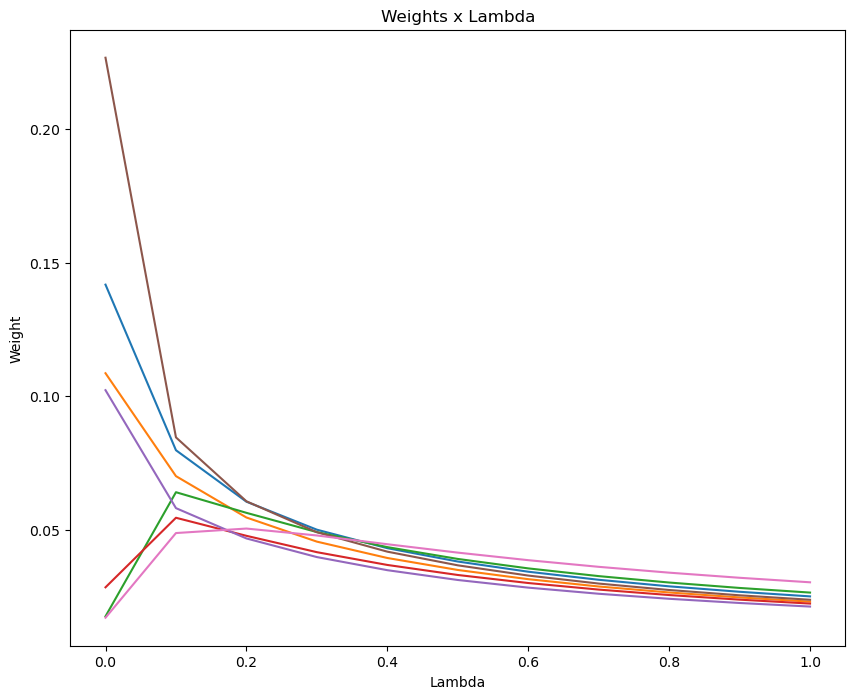

In [59]:
plt.figure(figsize=(10, 8))
for i in range(0, len(features)):
    plt.plot(lambda_reg_vals, ws[i])
plt.title('Weights x Lambda')
plt.xlabel('Lambda')
plt.ylabel('Weight')

- Vemos que quando aumentamos suficientemente o valor de lambda, os pesos tendem a diminuir e a ficarem próximos de zero, que é justamente a característica de uma Regularização $L_{2}$.

- Poderíamos analisar também a distribuição dos pesos em cada modelo, verificando que se aproxima de uma distribuição normal na medida em que aumentamos o valor de $\lambda$. No entanto, como há poucas features, a visualização de tal processo não é boa.